<a href="https://colab.research.google.com/github/Kadeian/reimagined-octo-disco/blob/master/Evaluating_the_Text_Generation_of_Large_Language_Models_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1><b>Text-to-Text tasks with LLMs</b>
</center>

# Objectives

- Illustrate prompt engineering for text-to-text tasks using Llama 2.
- Build and evaluate LLMs for text-to-text tasks using appropriate metrics (e.g., ROUGE score and BERTscore).

In this notebook, we will take a closer look at two important text $→$ text tasks (summarization and question-answering), setting up the problems, metrics, evaluations with a view to devise prompts that achieve high performance on these evaluations.

In [ ]:
# Installation for GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.2.28  --force-reinstall --upgrade --no-cache-dir -q
# For downloading the models from HF Hub
!pip install huggingface_hub==0.23.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 247.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 154.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.0.0 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.0.0 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.0.0 which is incompatible.
ibis-framework 8.0.0 requires numpy<2,>=1, but you have numpy 2.0.0 which is incompatible.
numba 0.58.1 requires numpy<1.27,>=1

In [ ]:
#download datasets evaluate rouge_score and bert score
!pip install -q datasets==3.0.0 evaluate==0.4.3 rouge_score==0.1.2 bert-score==0.3.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.25.2

  Using cached numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.0
    Uninstalling numpy-2.0.0:
      Successfully uninstalled numpy-2.0.0


In [ ]:
import json
import numpy as np
import pandas as pd
import evaluate
from datasets import load_dataset
from collections import Counter
from tqdm import tqdm
import torch
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

In [ ]:
llama_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
llama_basename = "llama-2-13b-chat.Q5_K_M.gguf"
llama_path = hf_hub_download(
    repo_id=llama_name_or_path,
    filename=llama_basename
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [ ]:
lcpp_llm = Llama(
        model_path=llama_path,
        n_threads=2,  # CPU cores
        n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
        n_gpu_layers=43,  # Change this value based on your model and your GPU VRAM pool.
        n_ctx=4096,  # Context window
    )

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 1 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


### Step 2: Assemble data

With the objective and metrics out of the way, let us now assemble the data for this use case. As in the case text classification, a dataset is a task-specific subset of a corpus.

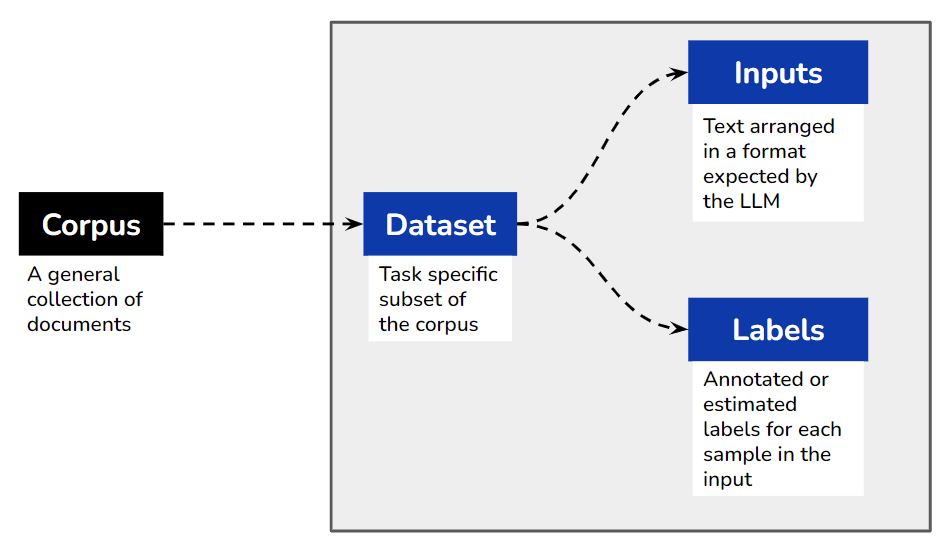

The key difference here is that the labels are not drawn from a predefined distribution. Construction of labels for text $→$ text tasks involves more effort, usually requiring multiple labelers that [brings its own challenges](https://www.databricks.com/blog/2023/04/12/dolly-first-open-commercially-viable-instruction-tuned-llm).

For the abstractive summarization exercise, we use a [dataset of conversations and their summaries](https://huggingface.co/datasets/knkarthick/dialogsum), where each dialogue was summarized by a human. These dialogues belong to a wide variety of topics (7434 in total). We use this dataset to showcase how custom datasets should be prepared and used for prompt engineering.

In [ ]:
dataset = load_dataset("pgurazada1/dialogsum")

Generating examples split: 0 examples [00:00, ? examples/s]

Generating gold_examples split: 0 examples [00:00, ? examples/s]

In [ ]:
dialogue_summary_examples_df = dataset['examples'].to_pandas()
dialogue_summary_gold_examples_df = dataset['gold_examples'].to_pandas()
examples_df = dialogue_summary_examples_df.sample(4)
examples_df

,dialogue,summary
31,#Person1#: What are the best places to visit h...,#Person2#'s showing #Person1# around New York ...
0,#Person1#: Have you gone to school today?\n#Pe...,#Person1# couldn't go to school for the illnes...
17,"#Person1#: Would you like something to drink, ...",#Person1# prepares coffee for #Person1#'s moth...
14,"#Person1#: This is tough to say, Jordan, but I...",Anna wants to break up with Jordan because the...


In [ ]:
for index, row in examples_df.iterrows():
 print('Example Dialogue:')
 print(row[0])
 print('Example Summary:')
 print(row[1])
 break

Example Dialogue:
#Person1#: What are the best places to visit here please?
#Person2#: It depends If you are interested in the city. you might like to tour it by car I can be your guide, We'll leave the afternoon free. You can do some shopping in the mall if you like.
#Person1#: Great. What do you suggest we see?
#Person2#: I suggest we visit the Metropolitan Museum of Art first, Now let's go. look people are jogging along the river. Here we are.
#Person1#: The exhibits are really special. I enjoy the paintings very much.
#Person2#: So do I. This is Broadway. There are lots of theaters. This way leads to Times Square.
Example Summary:
#Person2#'s showing #Person1# around New York and suggests visiting the Metropolitan Museum of Art first. #Person1# thinks the exhibits are special.


As we did for classification tasks, let us split the training data into two subsets - a 80% subset from which we draw the few-shot examples and a 20% subset from which we draw the gold examples.

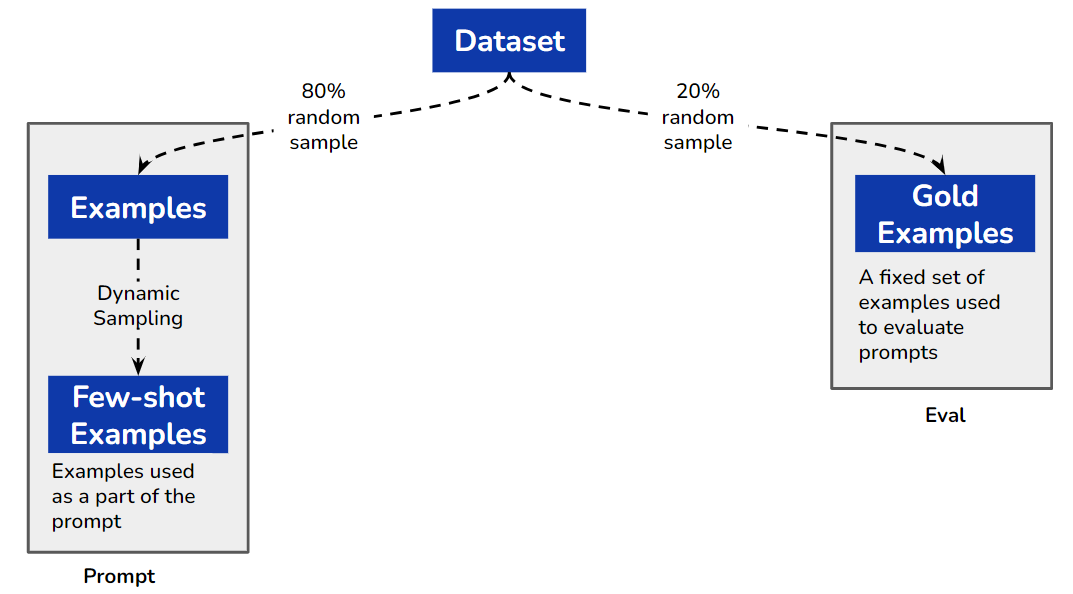

### Step 3: Derive prompt

In [ ]:
first_turn_template = """<s>[INST]\n <<SYS>> \n {system_message} \n <</SYS>>```{user_input}``` /n [/INST] \n{assistant_summary}\n</s> """
examples_template = """<s>[INST]\n ```{user_input}``` \n [/INST] \n {assistant_summary}\n</s>"""
prediction_template = """<s>[INST]\n ```{user_input}```[/INST]"""

In [ ]:
system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

With the system message in place, we can now assemble a few-shot prompt. Notice how the construction of the few-shot prompt mirrors the function we created for classificiation tasks.

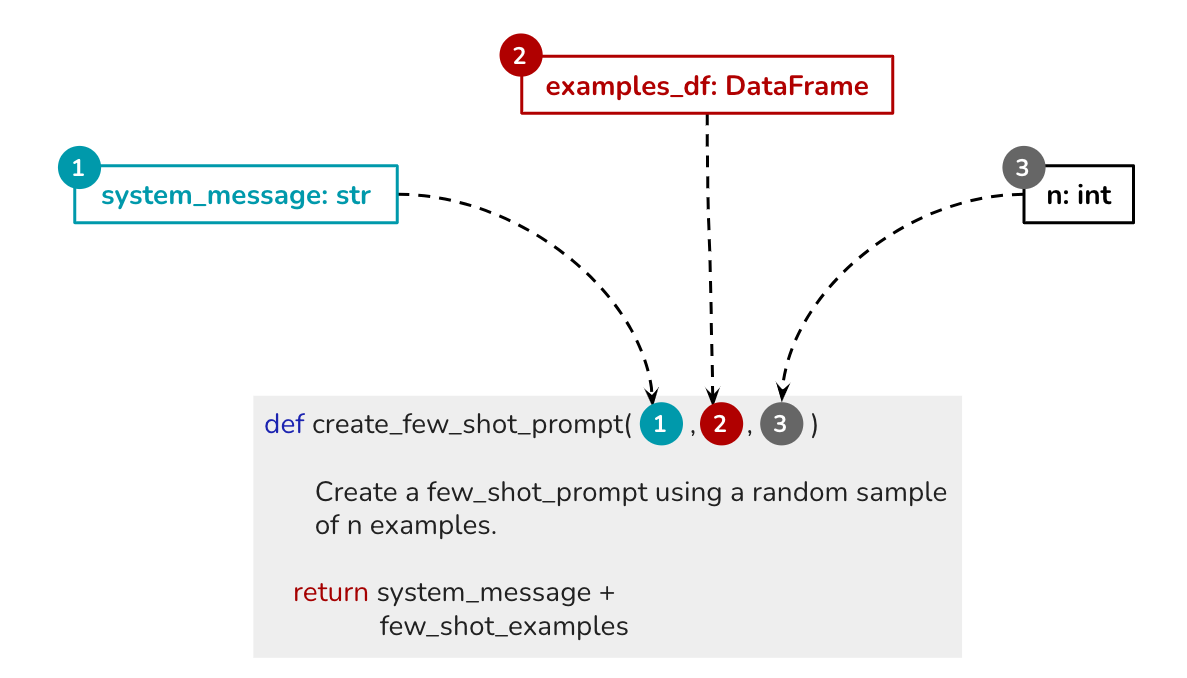

In [ ]:
def create_few_shot_prompt(system_message, examples,n=5):

    """
    Return a prompt message in the format expected by Llama 2.
    Loop through the examples and parse them as user message and assistant
    output.

    Args:
        system_message (str): system message with instructions for sentiment analysis
        examples (str): list of examples
        user_message_template (str): string with a placeholder for movie reviews

    Output:
        few_shot_prompt (str) : a string containing system message, user input and assistant output examples.
    """
    few_shot_prompt = ''

    for idx, row in examples.sample(n=5).iterrows():
        user_input_example = row[0]
        assistant_output_example = row[1]

        if idx == 0:
            few_shot_prompt += first_turn_template.format(
                system_message=system_message,
                user_input=user_input_example,
                assistant_summary=assistant_output_example)
        else:
            few_shot_prompt += examples_template.format(
                user_input=user_input_example,
                assistant_summary=assistant_output_example
            )

    return few_shot_prompt

Each time this function is executed, a new set of examples is sampled and a prompt is created.

In [ ]:
few_shot_prompt = create_few_shot_prompt(
    system_message,
    dialogue_summary_examples_df
)

In [ ]:
print(few_shot_prompt)

<s>[INST]
 ```#Person1#: When could we meet to discuss the project?
#Person2#: I will be available on Monday or Tuesday. Choose which day is best for you.
#Person1#: I prefer Monday.
#Person2#: Good. Can you come in the morning or would afternoon be best?
#Person1#: Either one is OK.
#Person2#: Great! When I check with the others, I will send you an exact time. When you come, be prepared to do your presentation.
#Person1#: I will be prepared to do my presentation.
#Person2#: Who would you like to see there? Just the sub-committee or should we ask the whole committee?
#Person1#: Everyone needs to be there.
#Person2#: That will probably be best. Do you need help with directions?
#Person1#: I think I know where it is. Maybe you could send me directions just to make sure.
#Person2#: OK. We will e-mail you all the information you need tomorrow. Have a good day!``` 
 [/INST] 
 #Person1# and #Person2# schedules their project discussion. #Person2# asks #Person1# to prepare the presentation and

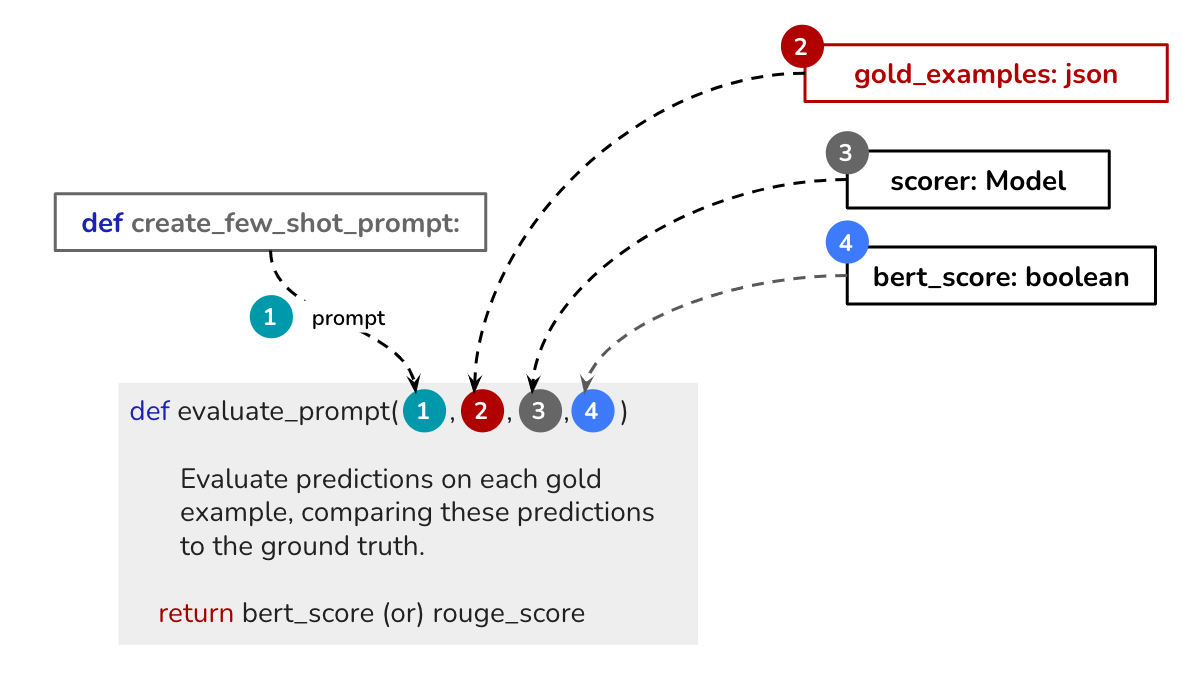

In [ ]:
def evaluate_prediction(prompt, gold_examples):

    """
    Return a dictionary of ground truths and model prediction.
    For each example, we make a prediction using the prompt.  Actual sentiments and
    model predictions are aggregated into a dictionary

    Args:
        prompt (str) : a string containing system message, user input and assistant output examples.
        gold_examples (str): JSON string with list of gold examples
        user_message_template (str): string with a placeholder for movie reviews

    Output:
        result (dictionary): actual sentiments and
    model predictions are aggregated into a dictionary
    """

    model_predictions, ground_truths = [], []
    for index, row in tqdm(gold_examples.iterrows()):
        gold_dialogue=row[0]
        gold_summary=row[1]
        user_input = prediction_template.format(
            user_input=gold_dialogue)

        try:
            response = lcpp_llm(
                prompt=prompt+user_input,
                max_tokens=128,
                temperature=0,
                top_p=0.95,
                repeat_penalty=1.2,
                echo=False # do not return the prompt
            )

            prediction = response["choices"][0]["text"]

            model_predictions.append(prediction)
            ground_truths.append(gold_summary)


        except Exception as e:
            print(e) # Log error and continue
            continue

    return {'model_predictions':model_predictions, 'ground_truths':ground_truths}

In [ ]:
examples_df =dialogue_summary_gold_examples_df.sample(4)

In [ ]:
result = evaluate_prediction(
    few_shot_prompt,
   examples_df
)

0it [00:00, ?it/s]Llama.generate: prefix-match hit
1it [00:49, 49.43s/it]Llama.generate: prefix-match hit
2it [01:11, 33.48s/it]Llama.generate: prefix-match hit
3it [01:45, 33.59s/it]Llama.generate: prefix-match hit
4it [02:31, 37.99s/it]


In [ ]:
print(result)

{'model_predictions': ["  Sure! Here is the dialogue with the correct punctuation and capitalization:\n\n#Person1:# Excuse me, could you tell me where Peking University is on this map?\n\n#Person2:# Let me see. Here it is.\n\n#Person1:# Could you tell me how to get there?\n\n#Person2:# I'm afraid I can't because I'm a stranger here.\n\n#Person1:# Oh, thanks all the same.\n\n#Person2:# Not at all. You can ask the policeman over there.", "  Oops! It looks like #Person2# has some 'splainin to do!", '  #Person1# is a teenager who works for #Person2# on Saturdays to earn money for a bike. #Person2# has a broken leg and needs help with household tasks, which #Person1# helps with in addition to taking care of the dog Oscar.', "  Sure! Here's the dialogue with the requested changes:\n\n#Person1#: I'm coming to pick up my ticket. This is my reservation note.\n#Person2#: Your reservation is right. Please get a ticket booking form from there and fill it out.\n#Person1#: Here you are. How much is 

In [ ]:
def evaluate_score(result, scorer, bert_score=False):

    """
    Return the ROUGE score or BERTScore for predictions on gold examples
    For each example we make a prediction using the prompt.
    Gold summaries and the AI generated summaries are aggregated into lists.
    These lists are used by the corresponding scorers to compute metrics.
    Since BERTScore is computed for each candidate-reference pair, we take the
    average F1 score across the gold examples.

    Args:
        prompt (List): list of messages in the Open AI prompt format
        gold_examples (str): JSON string with list of gold examples
        scorer (function): Scorer function used to compute the ROUGE score or the
                           BERTScore
        bert_score (boolean): A flag variable that indicates if BERTScore should
                              be used as the metric.

    Output:
        score (float): BERTScore or ROUGE score computed by comparing model predictions
                       with ground truth
    """

    model_predictions = result['model_predictions']
    ground_truths = result['ground_truths']
    if bert_score:
        score = scorer.compute(
            predictions=model_predictions,
            references=ground_truths,
            lang="en",
            rescale_with_baseline=True
        )

        return sum(score['f1'])/len(score['f1'])
    else:
        return scorer.compute(
            predictions=model_predictions,
            references=ground_truths
        )

In [ ]:
rouge_scorer = evaluate.load("rouge")
bert_scorer = evaluate.load("bertscore")

In [ ]:
rouge_score=evaluate_score(
    result,
    rouge_scorer
)

In [ ]:
print(rouge_score)

{'rouge1': 0.19034202410989629, 'rouge2': 0.03125, 'rougeL': 0.12179702831511073, 'rougeLsum': 0.1522848331931595}


In [ ]:
bert_score=evaluate_score(result,
    bert_scorer,
    bert_score=True)

In [ ]:
print(bert_score)

0.0923854922875762
